<a href="https://colab.research.google.com/github/sebasmos/satellite.extractor/blob/main/satellite_images_hashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hash encrypting for satellite imagery 

The goal of hash encrypting is to create a unique fingerprint for each image per epiweek, so that even the change of color on a single pixel creates a different hash and thus to evaluate "neighboring spatio-temporal images based on epiweek calendar". For this purpose, image duplicate verification (i.e., checksums) is tested with sha-256, MD5 hash, and dhash(difference hash), obtaining best results for the last one using a hashsize of 8 pixels while squaring the horizontal gradients to obtain a lightweight hash per image. The last demonstrates to be useful to identify perceptually identical images, i.e, duplicate images captured during the data collection process with satellite extractor

In [1]:
!pip install epiweeks

### Utility functions

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os
import time
import sys
sys.path.insert(0,'..')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import  mean_absolute_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import seaborn as sns
from scipy import signal
import pickle

from sklearn.decomposition import PCA

from epiweeks import Week, Year
from datetime import date

from datetime import date

from random import randint, randrange
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

import skimage
import cv2
import os
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
import matplotlib.pyplot as plt
!echo "Libraries ready"
def readImg(img_path, resize_ratio=None, normalize = True):
  img = io.imread(img_path)
  img_F =img.copy()
  if resize_ratio:
    img_F = rescale(img, resize_ratio, anti_aliasing=True)
  
  path_img = os.path.basename(img_path)
  if normalize:
      CHANNELS = range(12)
      img_F = np.dstack([
          skimage.exposure.rescale_intensity(img_F[:,:,c], out_range=(0, 1)) 
          for c in CHANNELS])
    
  print(path_img, '(origin shape:', img.shape, '-> rescale:', str(img_F.shape) + ')')
  return img_F, path_img

  
# Load data from one of the source
def loadData(csv_folder, img_folder, option=None, resize_ratio=None):
  if option is None:
    # Get data by combining from csv and images
    df = loadStructuredData(csv_folder)
    info_dict = combineData(img_folder, df, resize_ratio)
    
    print(len(info_dict['LastDayWeek']), len(info_dict['Image']), len(info_dict['cases_medellin']))

  else:
    # Load data from previous pickle file
    info_dict = 1#loadDataFromPickle(option)
  return info_dict
  

def loadStructuredData(csv_path):
  df = pd.DataFrame()
  if os.path.isdir(csv_path):
    for filename in os.listdir(csv_path):
      file_path = os.path.join(csv_path, filename)
      df = df.append(pd.read_csv(file_path))
  elif os.path.isfile(csv_path):
    df = pd.read_csv(csv_path)
  else:
    print('Error: Not folder or file')
  return df
  
def getEpiWeek(origin_str):
  """Get epi week from string
  """
  date_ls = origin_str.split('-')
  return Week.fromdate(date(int(date_ls[0]), int(date_ls[1]), int(date_ls[2])))
  
def combineData(img_folder, df, resize_ratio=None):
  info_dict = {'LastDayWeek':[], 'cases_medellin':[], 'Image':[], 'epi_week':[], 'path_name':[]}
  img_list = os.listdir(img_folder)

  for index, row in df.iterrows():
    name = row['LastDayWeek']
    week_df = str(getEpiWeek(name))
    case = row['cases_medellin']
    for img_name in img_list:
      
      # If image name is image_2017-12-24.tiff -> get 2017-12-24
      # Reference Links: https://www.w3schools.com/python/ref_string_join.asp, 
      #                  https://stackoverflow.com/questions/13174468/how-do-you-join-all-items-in-a-list/13175535
      new_img_name = ''.join(i for i in img_name if i.isdigit() or i == '-')      

      week_img = str(getEpiWeek(new_img_name))
      #print(f"{week_df} = {week_img}")
      if week_df == week_img:
        #print("ENTRO")
        img_path = os.path.join(img_folder, img_name)
        img, img_path = readImg(img_path, resize_ratio)
        print(f"path {img_path} : {img.dtype} - {np.unique(img)}")
        info_dict['Image'].append(np.array(img).astype("float32"))
        info_dict['LastDayWeek'].append(name)
        info_dict['cases_medellin'].append(case)
        info_dict['epi_week'].append(week_df)
        info_dict['path_name'].append(img_path)
        break

  return info_dict

def splitTrainTestSet(ratio):
  # Split the data into training (ratio) and testing (1 - ratio)
  train_val_ratio = ratio
  train_num = int(len(info_dict['Image']) * train_val_ratio)

  # Change list to array
  origin_dimension_X = np.array(info_dict['Image'])
  labels = np.array(info_dict['cases_medellin'])

  print(''.center(60,'-'))

  origin_X_train = origin_dimension_X[:train_num,:,:,:]
  y_train = labels[:train_num]
  origin_X_test = origin_dimension_X[train_num:,:,:,:]
  y_test = labels[train_num:]

  # print('Total number of weeks:'.ljust(30), len(origin_dimension_X), 'weeks')
  # print('Training input:'.ljust(30), origin_X_train.shape)
  # print('Training output:'.ljust(30), y_train.shape)
  # print('Testing input:'.ljust(30), origin_X_test.shape)
  # print('Testing output:'.ljust(30), y_test.shape) 

  # return origin_X_train, y_train, origin_X_test, y_test


Libraries ready


### Download metadata:
url = "https://drive.google.com/u/0/uc?id=1RGrXHgvn60L4pHA40M0R0scszHLno5fD&export=download"

url = "https://drive.google.com/file/d/1RGrXHgvn60L4pHA40M0R0scszHLno5fD/view?usp=sharing"

In [3]:
"""
!gdown --id 1RGrXHgvn60L4pHA40M0R0scszHLno5fD
!unzip "dengue.zip" -d .
!rm -f dengue.zip
"""
!gdown --id 1x-A6uc91FS3HePSy11vxGJjP0qMqyhyF
#!unzip "dengue.zip" -d .
#!rm -f dengue.zip

/home/sebasmos/anaconda3/envs/sebasmos/lib/python3.9/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
^C


### Get data from bucket

In [2]:
import oci
import sys
import json
import os
import skimage
from tifffile import imread, imwrite
import numpy as np

In [ ]:
# Object Storage Parameters (for building a connection)
os_namespace = 'idfgbkbot6fd'
os_bucket = 'Sentinel_2_Images'
os_cmpt = 'ocid1.compartment.oc1..aaaaaaaamgl2tu5vh7mcyjsd2h7tq5umvcq6ivcjftljmzaq53kct6khrd7q'
os_tenancy = 'ocid1.tenancy.oc1..aaaaaaaas5kw6lnv6emziaapx3zdew6pqqd4xsnsovdlft3is6dy6skkg57q'

# Resource Principal for connecting to Object Storage/Logs
signer = oci.auth.signers.get_resource_principals_signer()
client = oci.object_storage.ObjectStorageClient(config={}, signer=signer, timeout=(100, 100))
objects = client.list_objects(namespace_name=os_namespace,
                        bucket_name=os_bucket)
destination = "/home/datascience"
OUTPUT = "DATASET_5_best_cities"

In [ ]:
def download_bucket(OUTPUT, 
                   os_namespace,
                   os_bucket,
                   objects):
    i = 0
    for obj in objects.data.objects:
        if OUTPUT in obj.name and ("tiff" in obj.name):
            #print(f"Downloading image: {obj.name}")
            image = client.get_object(namespace_name=os_namespace,
                                bucket_name=os_bucket,
                                object_name=obj.name)
            local_path = os.path.join(destination, OUTPUT, obj.name.split('/')[1])
            if not os.path.exists(local_path):
                os.makedirs(local_path)

            image_bytes = io.BytesIO(image.data.content)

            filename = obj.name.split('/')[1]

            with open(os.path.join(destination, obj.name), "wb", buffering=0) as f:
                f.write(image.data.content)
            i+=1
    return print("Finished")

download_bucket(OUTPUT, 
                   os_namespace,
                   os_bucket,
                   objects
                   )

### Load dataset 

In [10]:
#csv_folder # "./data/merge_cases_temperature_WeeklyPrecipitation_timeseries.csv"
csv_folder = "/home/sebasmos/Desktop/satellite.extractor/data/merge_cases_temperature_WeeklyPrecipitation_timeseries.csv"
#img_folder = "/home/datascience/DATASET_5_best_cities/Medellín"
#img_folder = "/home/sebasmos/Desktop/DATASETS/DATASET_5_best_cities/Cali"
img_folder = "/home/sebasmos/Desktop/DATASETS/Dataset_10_best_cities/Dataset_10_best_cities/5001"

info_dict = loadData(csv_folder, img_folder, resize_ratio=(0.1, 0.1, 1))


image_2015-11-01.tiff (origin shape: (745, 747, 12) -> rescale: (74, 75, 12))
path image_2015-11-01.tiff : float64 - [0.00000000e+00 1.99208784e-04 2.07695380e-04 ... 9.98696502e-01
 9.99772698e-01 1.00000000e+00]
image_2015-11-08.tiff (origin shape: (745, 747, 12) -> rescale: (74, 75, 12))
path image_2015-11-08.tiff : float64 - [0.00000000e+00 1.99208784e-04 2.07695380e-04 ... 9.98696502e-01
 9.99772698e-01 1.00000000e+00]
image_2015-11-15.tiff (origin shape: (745, 747, 12) -> rescale: (74, 75, 12))
path image_2015-11-15.tiff : float64 - [0.00000000e+00 2.23868447e-04 2.37615749e-04 ... 9.96705803e-01
 9.98035512e-01 1.00000000e+00]
image_2015-11-22.tiff (origin shape: (745, 747, 12) -> rescale: (74, 75, 12))
path image_2015-11-22.tiff : float64 - [0.00000000e+00 2.23868447e-04 2.37615749e-04 ... 9.96705803e-01
 9.98035512e-01 1.00000000e+00]
image_2015-11-29.tiff (origin shape: (745, 747, 12) -> rescale: (74, 75, 12))
path image_2015-11-29.tiff : float64 - [0.00000000e+00 5.18326546e

In [11]:
# Change list to array
df_med = np.array(info_dict['Image'])
labels = np.array(info_dict['cases_medellin'])
img_names = np.array(info_dict['path_name'])

print("Checking errors: ",[print(x.dtype) for x in  info_dict['Image'] if x.dtype!=np.float32])
print(''.center(60,'-'))
print(f"shape origin_dimension_X: {df_med.shape}")
print(f"labels {labels.shape}")
#print(f"labels {paths.shape}")
# Filter channels
df_med_rgb = df_med[:,:,:,1:4]
df_med_rgb = np.array(df_med_rgb)

Checking errors:  []
------------------------------------------------------------
shape origin_dimension_X: (164, 74, 75, 12)
labels (164,)


In [12]:
N_SIZE = len(img_names)
df_test = df_med_rgb[:N_SIZE]
path_test = img_names[:N_SIZE]
print(df_test.shape)
print(path_test.shape)

(164, 74, 75, 3)
(164,)


### Similarity analysis based on [hash imag](https://github.com/JohannesBuchner/imagehash)

In [13]:
#!pip install ImageHash
#! pip install imutils
import cv2 
from PIL import Image
#import imagehash
from imutils import paths
import argparse
import time
import sys
import cv2
import os
%matplotlib inline

In [14]:
def hash_difference(image, hashSize=8):
	resized = cv2.resize(image, (hashSize + 1, hashSize))
	diff = resized[:, 1:] > resized[:, :-1]
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [15]:
dict_hash = []
for img in df_test:
  img_float32 = np.float32(img)
  image = cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB)
  imageHash = hash_difference(image)
  dict_hash.append(imageHash)

data = {"img_hash": dict_hash,
        "img_names": path_test }
df = pd.DataFrame(data = data)

In [47]:
df.head(10)

,img_hash,img_names
0,1511215997078489628766310105917801773720416964...,image_2015-11-01.tiff
1,1511215997078489628766310105917801773720416964...,image_2015-11-08.tiff
2,1511215997078489628766310105917801773720416964...,image_2015-11-15.tiff
3,1511215997078489628766310105917801773720416964...,image_2015-11-22.tiff
4,7710338368852537362275078422939206409274601072...,image_2015-11-29.tiff
5,7710338368852537362275078422939206409274601072...,image_2015-12-06.tiff
6,7710338368852537362275078422939206409274601072...,image_2015-12-13.tiff
7,7710338368852537362275078422939206409274601072...,image_2015-12-20.tiff
8,9654984389596686701765423309280580319799290041...,image_2015-12-27.tiff
9,9654984389596686701765423309280580319799290041...,image_2016-01-03.tiff


In [48]:
df.groupby("img_hash").count()

,img_names
img_hash,
1511215997078489628766310105917801773720416964787076664,4
1520854770397563050386043240890401162234513274286665791,2
10727801266265776719354609680168168338454167857194045380,1
10748789240474012982011772105264631513986788629002944575,1
10916078495537973027932069640448047990922841633635663872,2
...,...
6266350362369775518843310495745965591161921920124474912824,2
6271717422969419381372389995423558697724308186710597927423,9
6275571864622807388533218862811154864751461513534361309176,1


,img_hash,img_names
0,1529871413427214643333436312807021186831399800...,3
1,9793342560831213882128135393641259634328660943...,3
2,133279873849806824494862272,2
3,8603226952389949469003453872822796542196707058...,2
4,6179043013790792919811510792932783483557682821...,2
5,6179025008080632838466090914847612929023213014...,2
6,5501679984728228588852017588408894853563529852...,2
7,5002256674117198033944511626957774395952212073...,2
8,3825129863055180739949327331783602907336417525...,2
9,7724013697536937987845616888277379788556029817...,2


164


Text(0.5, 1.0, 'hashes per img')

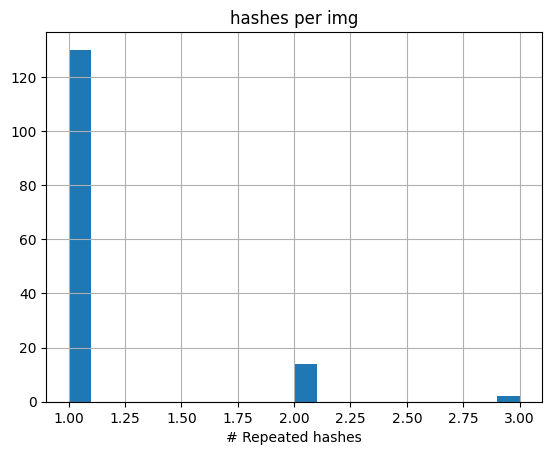

In [71]:
num_img_per_hash = df.groupby("img_hash").size().sort_values(ascending = False).reset_index(name = "img_names")
display(num_img_per_hash.head(10))
print(sum(num_img_per_hash["img_names"]))
num_img_per_hash.hist("img_names", bins = 20)
plt.xlabel('# Repeated hashes')
plt.title('hashes per img')

In [14]:
num_img_per_hash.nunique()

img_hash     91
img_names     5
dtype: int64

### Plotting *vertical* perspective: Frequency vs # images

,img_hash,img_names
0,1529871413427214643333436312807021186831399800...,3
1,9793342560831213882128135393641259634328660943...,3
2,133279873849806824494862272,2
3,8603226952389949469003453872822796542196707058...,2
4,6179043013790792919811510792932783483557682821...,2
5,6179025008080632838466090914847612929023213014...,2
6,5501679984728228588852017588408894853563529852...,2
7,5002256674117198033944511626957774395952212073...,2
8,3825129863055180739949327331783602907336417525...,2
9,7724013697536937987845616888277379788556029817...,2


164


<Figure size 640x480 with 0 Axes>

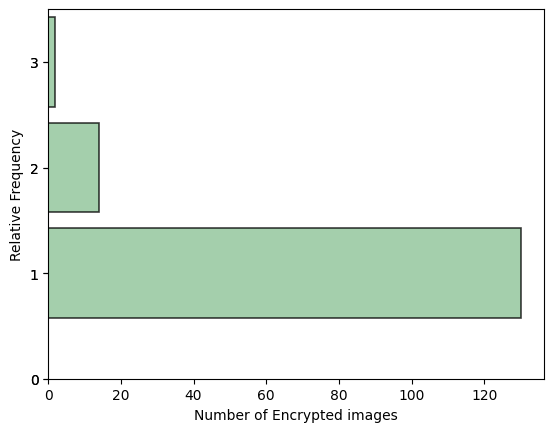

In [72]:
num_img_per_hash = df.groupby("img_hash").size().sort_values(ascending = False).reset_index(name = "img_names")
display(num_img_per_hash.head(10))
print(sum(num_img_per_hash["img_names"]))

def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])
ax = plt.figure()
num_img_per_hash.hist("img_names", 
                        bins = range(20), 
                        orientation = "horizontal", 
                        color='#86bf91',  
                        edgecolor='black', 
                        linewidth=1.2, 
                        align="left",
                        rwidth=0.85,
                        alpha=0.75)
plt.xlabel("Number of Encrypted images")
plt.ylabel("Relative Frequency")
plt.title('')
plt.ylim(0, num_img_per_hash.img_names[0]+0.5)
plt.grid(False)

# ------- 
# make the y ticks integers, not floats
yint = []
locs, labels = plt.yticks()
for each in locs:
    yint.append(int(each))
plt.yticks(yint)
# -------
plt.savefig('plot2.png', transparent=True)


In [ ]:
    a = 0
    root = config.DATASET
    for city in os.listdir(root):
        start_time = time.time()
        list_images = []
        images_path = os.path.join(root, city)
        print(f'{city} : {len(os.listdir(images_path))} images '.center(60,"-"))
        for img_path in os.listdir(images_path):
            path = os.path.join(root, city, img_path)
            print("Processing image ", os.path.join(root, city, img_path))
            img = utils.read_tiff(path, config.image_size, resize_ratio=config.resize_ratio, resizing = config.resizing, normalize=config.normalize, printing=config.printing)
            list_images.append(img)
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f'Training time for {city} : {total_time_str}')
        m = np.array(list_images)
        print(np.array(list_images).shape)
        dict_hash = []
        for img in m:
            imageHash = utils.hash_difference(img)
            dict_hash.append(imageHash)
        data = {"img_hash": dict_hash,"img_names": os.listdir(images_path) }
        df = pd.DataFrame(data = data)
        num_img_per_hash = df.groupby("img_hash").size().sort_values(ascending = False).reset_index(name = "img_names")
        print(num_img_per_hash)
        #display(num_img_per_hash.head(10))
        print(sum(num_img_per_hash["img_names"]))
        ax = plt.figure()
        num_img_per_hash.hist("img_names", bins = 20, orientation = "vertical",  color='#86bf91',  edgecolor='black', linewidth=1.2)
        plt.xlabel("Relative Frequency")
        plt.ylabel("Number of Encrypted images")
        plt.title('')
        plt.xlim(1, num_img_per_hash.img_names[0])
        plt.grid(False)

        # ------- 
        # make the y ticks integers, not floats
        xint = []
        locs, labels = plt.xticks()
        for each in locs:
            xint.append(int(each))
        plt.xticks(xint)
        # -------
        plt.savefig(f'{viz}/{city}.png', transparent=True)

### Plotting *horizontal* perspective: Frequency vs # images

,img_hash,img_names
0,1529871413427214643333436312807021186831399800...,3
1,9793342560831213882128135393641259634328660943...,3
2,133279873849806824494862272,2
3,8603226952389949469003453872822796542196707058...,2
4,6179043013790792919811510792932783483557682821...,2
5,6179025008080632838466090914847612929023213014...,2
6,5501679984728228588852017588408894853563529852...,2
7,5002256674117198033944511626957774395952212073...,2
8,3825129863055180739949327331783602907336417525...,2
9,7724013697536937987845616888277379788556029817...,2


164
2


<Figure size 640x480 with 0 Axes>

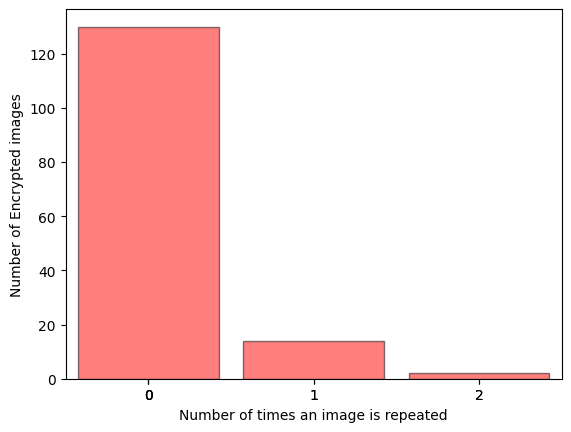

In [16]:
num_img_per_hash = df.groupby("img_hash").size().sort_values(ascending = False).reset_index(name = "img_names")
display(num_img_per_hash.head(10))
print(sum(num_img_per_hash["img_names"]))

num_img_per_hash.img_names = num_img_per_hash.img_names - 1 # Axis starts from 0

ax = plt.figure()
num_img_per_hash.hist("img_names", 
                        bins = range(20), 
                        orientation = "vertical", 
                        color='#FF0000',  
                        edgecolor='black', 
                        #linewidth=1.2, 
                        align="left",
                        rwidth=0.85,
                        alpha=0.5)
plt.xlabel("Number of times an image is repeated")
plt.ylabel("Number of Encrypted images")
plt.title('')                                       # Delete title
plt.xlim(-0.5, num_img_per_hash.img_names[0]+0.5)   # Starting axis from zero with 0.5 padding side-wise
plt.grid(False)
print(num_img_per_hash.img_names[0])
# Design x axis to be integer and avoid float metrics
xint = []
locs, labels = plt.xticks()
for each in locs:
    xint.append(int(each))
plt.xticks(xint)
# Store image
plt.savefig('plot2.png', transparent=True)


In [20]:
num_img_per_hash.img_names[0]

2

### Improved hashing for N cities

In [2]:
ROOT_DIR = "/home/sebasmos/Desktop/satellite.extractor/notebooks" 
a = 0
# "/home/sebasmos/Desktop/DATASETS/test"
root = "/home/sebasmos/Desktop/DATASETS/Dataset_10_best_cities/Dataset_10_best_cities"

In [18]:
import os
import matplotlib.pyplot as plt
import glob
import copy
import shutil
import random
import cv2
from skimage import io
from skimage.transform import rescale, resize
import skimage.exposure
import numpy as np
from PIL import Image
import time
from imutils import paths
import argparse
import time
import sys
%matplotlib inline
import pandas as pd

viz = os.path.join(ROOT_DIR, "data")
os.makedirs(viz, exist_ok=True)

def hash_difference(image, hashSize=8):
	resized = cv2.resize(image, (hashSize + 1, hashSize))
	diff = resized[:, 1:] > resized[:, :-1]
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

def read_tiff(img_path, image_size, resize_ratio=None, resizing = True, normalize=True, printing=True):
  img = io.imread(img_path)
  img_F =img.copy()
  if resize_ratio:
    img_F = rescale(img, resize_ratio, anti_aliasing=True)
  if resizing:
    img_F = resize(img_F, (image_size, image_size), anti_aliasing=True)
  
  path_img = os.path.basename(img_path)
  if normalize:
    CHANNELS = range(12)
    img_F = np.dstack([
        skimage.exposure.rescale_intensity(img_F[:,:,c], out_range=(0, 1)) 
        for c in CHANNELS])
  if printing:
    print(f"(origin shape: {path_img}: {img.shape} -> rescale: {str(img_F.shape)}) - Range -> [{img_F.min(), img_F.max()}]")
  return img_F
  
for city in os.listdir(root):
        start_time = time.time()
        list_images = []
        images_path = os.path.join(root, city)
        print(f'{city} : {len(os.listdir(images_path))} images '.center(60,"-"))
        for img_path in os.listdir(images_path):
            path = os.path.join(root, city, img_path)
            #print("Processing image ", os.path.join(root, city, img_path))
            img = read_tiff(path, 750, resize_ratio=(0.1,0.1,1), resizing = False, normalize=False, printing=True)
            list_images.append(img)
        m = np.array(list_images)
        print(np.array(list_images).shape)
        dict_hash = []
        for img in m:
            imageHash = hash_difference(img)
            dict_hash.append(imageHash)
        data = {"img_hash": dict_hash,"img_names": os.listdir(images_path) }
        df = pd.DataFrame(data = data)
        num_img_per_hash = df.groupby("img_hash").size().sort_values(ascending = False).reset_index(name = "img_names")
        num_img_per_hash.img_names = num_img_per_hash.img_names - 1 # Axis starts from 0
        ax = plt.figure()
        if num_img_per_hash.img_names[0]<=13:
          num_img_per_hash.hist("img_names", 
                                bins = range(20), 
                                orientation = "vertical",  
                                color='#FF0000',  
                                edgecolor='black', 
                                linewidth=1.2,
                                rwidth=0.85,
                                alpha=0.5,
                                align="left")
        
        else:
          num_img_per_hash.hist("img_names", 
                                bins = 20, 
                                orientation = "vertical",  
                                color='#FF0000',  
                                edgecolor='black', 
                                linewidth=1.2,
                                alpha=0.5,
                                align="mid")
        
        plt.xlabel("Number of times an image is repeated")
        plt.ylabel("Number of Encrypted images")
        plt.title('')
        plt.xlim(-1, num_img_per_hash.img_names[0]+0.5)
        plt.grid(False)

        # ------- 
        # make the y ticks integers, not floats
        xint = []
        locs, labels = plt.xticks()
        for each in locs:
            xint.append(int(each))
        plt.xticks(xint)
        # -------
        plt.savefig(f'{viz}/{city}.png', transparent=True)

--------------------41001 : 165 images ---------------------
(origin shape: image_2018-04-29.tiff: (749, 743, 12) -> rescale: (75, 74, 12)) - Range -> [(0.11372549019607843, 0.8627450980392157)]
(origin shape: image_2017-08-13.tiff: (749, 743, 12) -> rescale: (75, 74, 12)) - Range -> [(0.0, 0.0)]
(origin shape: image_2017-02-05.tiff: (745, 747, 12) -> rescale: (74, 75, 12)) - Range -> [(0.011764705882352941, 0.41585479597244285)]
(origin shape: image_2015-12-13.tiff: (749, 743, 12) -> rescale: (75, 74, 12)) - Range -> [(0.0, 0.0)]
(origin shape: image_2018-05-27.tiff: (745, 747, 12) -> rescale: (74, 75, 12)) - Range -> [(0.0, 0.6039745627980928)]
(origin shape: image_2018-07-08.tiff: (747, 746, 12) -> rescale: (75, 75, 12)) - Range -> [(0.0, 0.996078431372549)]
(origin shape: image_2018-10-07.tiff: (745, 747, 12) -> rescale: (74, 75, 12)) - Range -> [(0.0, 0.9882352941176471)]
(origin shape: image_2018-12-02.tiff: (746, 746, 12) -> rescale: (75, 75, 12)) - Range -> [(0.0039215686274509

/tmp/ipykernel_5527/2369615631.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = np.array(list_images)
/tmp/ipykernel_5527/2369615631.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(list_images).shape)


(origin shape: image_2018-04-29.tiff: (745, 748, 12) -> rescale: (74, 75, 12)) - Range -> [(0.0, 0.8954700582935882)]
(origin shape: image_2017-08-13.tiff: (745, 748, 12) -> rescale: (74, 75, 12)) - Range -> [(0.0, 0.9575242889948768)]
(origin shape: image_2017-02-05.tiff: (745, 748, 12) -> rescale: (74, 75, 12)) - Range -> [(0.0, 0.7867912029676739)]
(origin shape: image_2015-12-13.tiff: (745, 748, 12) -> rescale: (74, 75, 12)) - Range -> [(0.0, 0.6675536124359582)]
(origin shape: image_2018-05-27.tiff: (745, 748, 12) -> rescale: (74, 75, 12)) - Range -> [(0.06666666666666667, 0.6823529411764706)]
(origin shape: image_2018-07-08.tiff: (745, 748, 12) -> rescale: (74, 75, 12)) - Range -> [(0.00392156862745098, 0.7564559265147498)]
(origin shape: image_2018-10-07.tiff: (745, 748, 12) -> rescale: (74, 75, 12)) - Range -> [(0.0, 0.42373785550256166)]
(origin shape: image_2018-12-02.tiff: (745, 748, 12) -> rescale: (74, 75, 12)) - Range -> [(0.0, 0.913582405935347)]
(origin shape: image_201

([<matplotlib.axis.XTick at 0x7f75b6182280>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 640x480 with 0 Axes>

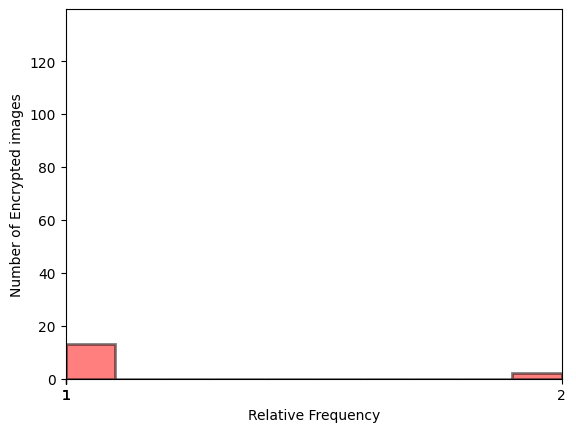

In [13]:
ax = plt.figure()
num_img_per_hash.hist("img_names", 
                      bins = 20, orientation = "vertical",  color='#FF0000',  
                      edgecolor='black', 
                      linewidth=2,
                      rwidth=2, 
                      alpha=0.5)
plt.xlabel("Relative Frequency")
plt.ylabel("Number of Encrypted images")
plt.title('')
plt.xlim(1, num_img_per_hash.img_names[0])
plt.grid(False)
xint = []
locs, labels = plt.xticks()
for each in locs:
            xint.append(int(each))
plt.xticks(xint)

* **Remarks on image hashing for high-cloud inteference**

The data used corresponds to Dengue Satellite data of Colombia, extracted for MIT critical Data Colombia, in open-source collaboration with the University of Bordeaux, Autonomous University of Madrid, and Pázmány Péter Catholic University. 

[Satellite-collector](https://github.com/sebasmos/satellite.extractor/blob/main/linux/request_multiple_images_by_slots.py) algorithm selects the best image per week when there is an image with the least interference during the same week; if otherwise - when all images are totally occluded due to cloud interference, an extra day from the following week is added into the epiweek consecutively, until a better image than the ones within this pool is captured.

Despite the mosaicking order is based on the LeastCC algorithm, the fact that there can be cloud-occluded images during months means that there can be images that can be repeated a certain number of times within the downloaded dataset (around a month would be reasonable in most places, but this would depend of the local ecosystems and satellite measurement conditions). As examplified by the worst-case scenario, when every day it is totally covered by clouds, we expect to encounter cases when a very same image (with the same hash) might be repeated several times, e.g. in the case of some tropical areas like Amazonas (one of the most tropical places on earth), it can be cloudy up to 4 consecutive months from December to April, meaning that an image could be repeated up to 16 times in a row. 

The most effective way to analyse this periodic behaviour is using hashes, which maps a data structure of arbitrary size to fixed-sized data. In our case, we use the hashes to create a hash-image dictionary and compare how often the images repeat over the entire dataset tagged by the name correspoding to the image. On the case above, we counted with the satellite data extracted from [satellite extractor](https://github.com/sebasmos/satellite.extractor), which contains 146 images from the city of Medellin and from which we observed that two images repeated a maximum number of three times, meaning that this city was totally occluded by clouds during a month. In order to download the images from sentinel-hub API, a script request is configured using the least amount of clouds per epi week where the satellite image with least amount of clouds is selected to create a curated dataset.  *However this is not common, as it can be seen that there are duplicated images for less than 18 images out of 146, whilst all the other images preserve a unique hash, meaning that each image is unique in resolution and is different from each other in 80 % of the time for the city of Medellin*. A similar analysis can be performed for any dataset, from any city and from any type of dataset.  


From this analysis, we concluded that the images we downloaded are each unique and can be used for change-detection analysis and dengue forecasting, as there are geographical places where rainy days can last for months and therefore it is natural to encounter totally occluded images during certain months, however this can be represented in less than 15 % of the data, meaning that more pre-processing could be performed to deal with the cloud interference problem. Besides, vector-borne diseases are highly correlated with coulds as they relate to temperature, so there might be a relationship between mosquito migration sparsity and the 15% of cloud interference on this dataset.


### References
https://realpython.com/python-histograms/ 